# 1. Data preprocess & expolore

## 1.1 Make dataframe with raw data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import notebook
from pathlib import Path
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- Check nan values

- Just use observation after 3:
- Make price & return dataframe

In [5]:
path = '/content/drive/MyDrive/중국 선물/data/'

In [6]:
group1 = pd.read_csv(path + 'group1_log_dif.csv', index_col =0, parse_dates = True)
group1_price = pd.read_csv(path + 'group1_log.csv', index_col =0, parse_dates = True)

In [7]:
group1.head()

,KQ.m@DCE.b,KQ.m@DCE.m,KQ.m@CZCE.RM
datetime,,,
2020-08-03 09:01:00,0.000000,-0.001374,-0.001263
2020-08-03 09:02:00,0.003254,0.002060,0.002104
2020-08-03 09:03:00,-0.000591,-0.001029,-0.001262
2020-08-03 09:04:00,0.001771,0.001029,0.000000
2020-08-03 09:05:00,-0.002658,-0.001716,-0.001685


In [ ]:
group1_price.head()

,KQ.m@DCE.b,KQ.m@DCE.m,KQ.m@CZCE.RM
datetime,,,
2020-08-03 09:01:00,8.124151,7.975908,7.772332
2020-08-03 09:02:00,8.127405,7.977968,7.774436
2020-08-03 09:03:00,8.126814,7.976939,7.773174
2020-08-03 09:04:00,8.128585,7.977968,7.773174
2020-08-03 09:05:00,8.125927,7.976252,7.771489


## 1.2 Expore price & return

 - Summary stat

In [8]:
from scipy.stats import skew, kurtosis
from statsmodels.stats.stattools import jarque_bera

def desc_statics(data):
    describe = data.describe()
    # 왜도
    describe.loc["skew"] = skew(data)

    # 첨도
    describe.loc["kurt"] = kurtosis(data, fisher = False)

    #자크베라
    describe.loc["j_b"] = jarque_bera(data)[0]
    
    return describe

### 선물 기초통계량

In [9]:
desc_statics(group1_price)

,KQ.m@DCE.b,KQ.m@DCE.m,KQ.m@CZCE.RM
count,20563.000000,20563.000000,20563.000000
mean,8.174324,8.023495,7.781329
std,0.050317,0.047286,0.030473
min,8.077137,7.949091,7.722235
25%,8.131237,7.979681,7.756195
50%,8.173575,8.028455,7.776115
75%,8.222554,8.070906,7.806696
max,8.255828,8.106816,7.849324
skew,-0.096631,0.172186,0.171084
kurt,1.652976,1.567064,1.879955


In [10]:
desc_statics(group1)

,KQ.m@DCE.b,KQ.m@DCE.m,KQ.m@CZCE.RM
count,2.056300e+04,2.056300e+04,2.056300e+04
mean,-1.321917e-07,-6.086143e-07,-2.826422e-06
std,9.525116e-04,5.532074e-04,1.025562e-03
min,-1.702169e-02,-3.241494e-03,-1.690914e-02
25%,-3.026176e-04,-3.348401e-04,-4.197272e-04
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.028926e-04,3.338341e-04,4.194631e-04
max,1.679277e-02,6.520750e-03,1.647198e-02
skew,7.798305e-02,2.579041e-01,-2.420863e-01
kurt,7.019032e+01,7.034105e+00,9.509650e+01


In [11]:
corr = group1.corr()
corr

,KQ.m@DCE.b,KQ.m@DCE.m,KQ.m@CZCE.RM
KQ.m@DCE.b,1.000000,0.423294,0.233572
KQ.m@DCE.m,0.423294,1.000000,0.400809
KQ.m@CZCE.RM,0.233572,0.400809,1.000000


- In this example standard scaler with price
- Originally, the exchange rate is applied
- Also you can use any scaler with scipy or etc...



# 2. Analysis


- predict model, pair trading

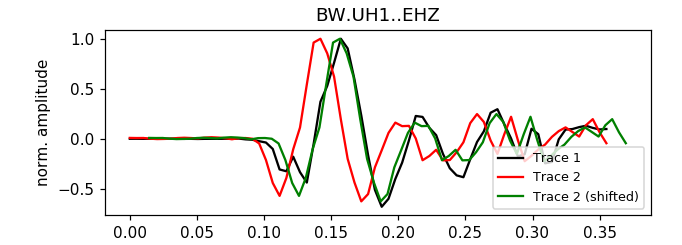

## 2.1 ADF 단위근 검정

In [ ]:
adftest_price = round(group1_price.apply(lambda x: adfuller(x, autolag = 'BIC')[0:2]).T,3)
adftest_price.columns = ['T-statics', 'P-values']

In [ ]:
adftest_price

,T-statics,P-values
KQ.m@DCE.b,-1.151,0.694
KQ.m@DCE.m,-1.022,0.745
KQ.m@CZCE.RM,-1.466,0.550


In [ ]:
adftest = round(group1.apply(lambda x: adfuller(x, autolag = 'BIC')[0:2]).T,3)
adftest.columns = ['T-statics', 'P-values']

In [ ]:
adftest # 모두 안정시계열

,T-statics,P-values
KQ.m@DCE.b,-97.135,0.0
KQ.m@DCE.m,-110.543,0.0
KQ.m@CZCE.RM,-22.436,0.0


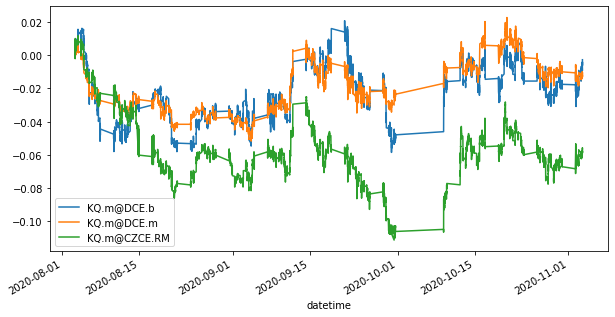

In [ ]:
group1.cumsum().plot(figsize = (10,5))

## 2.2 VAR summary

In [ ]:
from statsmodels.tsa.api import VAR

## 2.3 그래인저 인과관계

In [ ]:
def granger_causality(rtn):
    
    model = VAR(rtn)
    results = model.fit(maxlags=30, ic='bic')

    corr = rtn.corr()
    temp_F = pd.DataFrame().reindex_like(corr)
    
    for i in rtn.columns:
        for j in rtn.columns:
            stat = results.test_causality(i,j).summary()
            if i != j:
                f = stat.data[1][0]
                p = stat.data[1][2]
                temp_F.loc[i,j] = str(np.round(f, 3)) + {p < 0.1 : '(*)', p < 0.05 : '(**)', p < 0.01 : '(***)'}.get(True,'')
            
            else:
                temp_F.loc[i,j] = '-'
    print(f"Model lag order is : {results.k_ar}")
    return temp_F.T

In [ ]:
causal_group1 = granger_causality(group1[['KQ.m@DCE.m','KQ.m@CZCE.RM','KQ.m@DCE.b']])
causal_group1.columns = ['콩껍질', '유채씨껍질', '황두2호']
causal_group1.index = ['콩껍질', '유채씨껍질', '황두2호']

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Model lag order is : 4


In [ ]:
causal_group1

,콩껍질,유채씨껍질,황두2호
콩껍질,-,115.837(***),67.261(***)
유채씨껍질,9.369(***),-,3.003(**)
황두2호,14.662(***),6.483(***),-


## 2.4 충격반응함수

In [ ]:
model = VAR(group1[['KQ.m@DCE.m','KQ.m@CZCE.RM','KQ.m@DCE.b']])
results = model.fit(5, ic = 'bic')
irf = results.irf(10)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Dec, 2020
Time:                     07:51:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -43.4150
Nobs:                     20559.0    HQIC:                  -43.4252
Log likelihood:           358963.    FPE:                1.37581e-19
AIC:                     -43.4301    Det(Omega_mle):     1.37321e-19
--------------------------------------------------------------------
Results for equation KQ.m@DCE.m
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.000001         0.000004           -0.159           0.874
L1.KQ.m@DCE.m          -0.169629         0.008493          -19.973           0.000
L1.KQ.m@CZCE.RM         0.025660         0.0045

In [ ]:
round(results.params,6).astype(str) + results.pvalues.applymap(lambda x: {x < 0.1 : '(*)', x < 0.05 : '(**)', x < 0.01 : '(***)'}.get(True,'')) 

,KQ.m@DCE.m,KQ.m@CZCE.RM,KQ.m@DCE.b
const,-1e-06,-5e-06,-0.0
L1.KQ.m@DCE.m,-0.169629(***),0.287689(***),0.217334(***)
L1.KQ.m@CZCE.RM,0.02566(***),-0.471926(***),0.026022(***)
L1.KQ.m@DCE.b,0.035696(***),0.039744(***),-0.346038(***)
L2.KQ.m@DCE.m,-0.062408(***),0.190903(***),0.130756(***)
L2.KQ.m@CZCE.RM,0.016664(***),-0.281297(***),0.011075
L2.KQ.m@DCE.b,0.015263(***),0.02432(***),-0.158477(***)
L3.KQ.m@DCE.m,-0.042896(***),0.114384(***),0.052281(***)
L3.KQ.m@CZCE.RM,0.018032(***),-0.141927(***),0.007896
L3.KQ.m@DCE.b,0.012257(**),0.012371,-0.076974(***)


Figure(720x720)


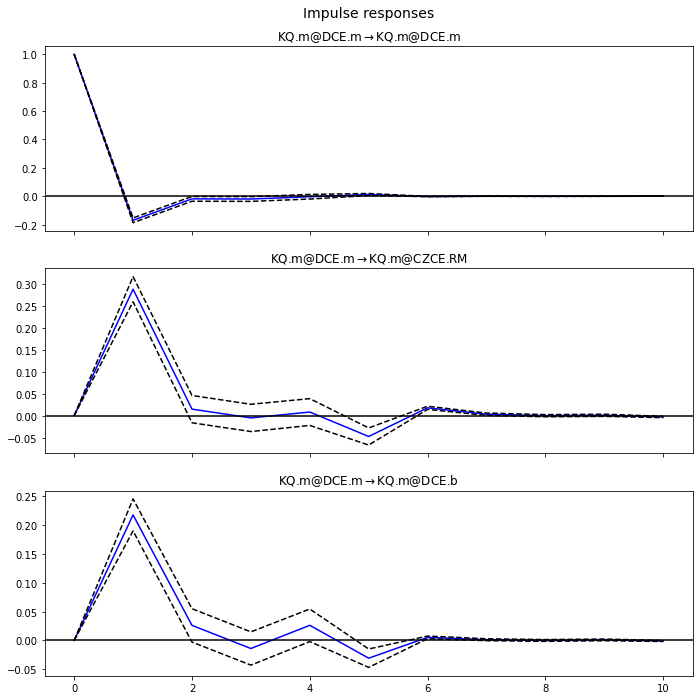

In [ ]:
print(irf.plot(impulse = 'KQ.m@DCE.m'))

In [ ]:
results.fevd(10).summary()

FEVD for KQ.m@DCE.m
     KQ.m@DCE.m  KQ.m@CZCE.RM  KQ.m@DCE.b
0      1.000000      0.000000    0.000000
1      0.995419      0.001881    0.002700
2      0.995410      0.001882    0.002708
3      0.995226      0.002019    0.002755
4      0.995217      0.002027    0.002756
5      0.995105      0.002112    0.002783
6      0.995096      0.002120    0.002784
7      0.995096      0.002120    0.002784
8      0.995095      0.002120    0.002784
9      0.995095      0.002120    0.002784

FEVD for KQ.m@CZCE.RM
     KQ.m@DCE.m  KQ.m@CZCE.RM  KQ.m@DCE.b
0      0.205197      0.794803    0.000000
1      0.175114      0.823910    0.000977
2      0.174938      0.824084    0.000977
3      0.174907      0.824110    0.000983
4      0.174883      0.824106    0.001011
5      0.174569      0.824389    0.001042
6      0.174519      0.824438    0.001044
7      0.174515      0.824441    0.001044
8      0.174515      0.824441    0.001044
9      0.174515      0.824441    0.001044

FEVD for KQ.m@DCE.b
     KQ.m@DC